In [2]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [3]:
# Load dataset
df = pd.read_csv("Data Jalan.csv")

# Tampilkan 5 baris pertama dari dataset
data.head()

,No Ruas,Nama Ruas Jalan,Kecamatan Yang Dilalui,Panjang Ruas,Lebar Ruas,Jenis Perkesaran (Km),Panjang Tiap Kondisi Sedang (%),Panjang Tiap Kondisi Baik (Km),Panjang Tiap Kondisi Rusak Ringan (%),Panjang Tiap Kondisi Rusak Berat (%),Akses Ke N/P/K,Rusak Ringan (%),Rusak Berat (%),Total Kerusakan (%),Kelas Kerusakan,Prediksi Kelas,Prioritas
0,1,JL. PEMUDA,PATI,1.24,11.0,1.24,64.52%,0.44,0%,0%,K,0.0,0.0,0.0,Rendah,Rendah,3
1,2,JL. P. SUDIRMAN,PATI,1.45,11.0,1.45,41.38%,0.85,0%,0%,K,0.0,0.0,0.0,Rendah,Rendah,3
2,3,JL. Dr. SUSANTO,PATI,1.02,11.0,1.02,80.39%,0.20,0%,0%,K,0.0,0.0,0.0,Rendah,Rendah,3
3,4,JL. Dr. WAHIDIN,PATI,0.42,11.0,0.42,54.76%,0.19,0%,0%,K,0.0,0.0,0.0,Rendah,Rendah,3
4,5,JL. ALUN-ALUN PATI,PATI,0.43,14.0,0.43,-,0.43,0%,0%,K,0.0,0.0,0.0,Rendah,Rendah,3


In [4]:
# Salin dataframe
data = df.copy()

In [5]:
# Hapus baris kosong atau tidak valid
data = data.replace('-', np.nan).dropna()

In [6]:
# Konversi persen ke float
def percent_to_float(x):
    return float(str(x).replace('%', '')) if isinstance(x, str) else x

data['Rusak Ringan (%)'] = data['Panjang Tiap Kondisi Rusak Ringan (%)'].apply(percent_to_float)
data['Rusak Berat (%)'] = data['Panjang Tiap Kondisi Rusak Berat (%)'].apply(percent_to_float)
data['Total Kerusakan (%)'] = data['Rusak Ringan (%)'] + data['Rusak Berat (%)']

In [7]:
# Klasifikasi tingkat kerusakan
def klasifikasi_kerusakan(persen):
    if persen >= 50:
        return 'Tinggi'
    elif persen >= 20:
        return 'Sedang'
    else:
        return 'Rendah'

data['Kelas Kerusakan'] = data['Total Kerusakan (%)'].apply(klasifikasi_kerusakan)

In [8]:
# Bersihkan kolom Lebar Ruas
def bersihkan_lebar(lebar_str):
    if isinstance(lebar_str, str):
        lebar_str = lebar_str.replace(',', '.')
        if '-' in lebar_str:
            angka = re.findall(r'\d+\.?\d*', lebar_str)
            if len(angka) == 2:
                return (float(angka[0]) + float(angka[1])) / 2
        try:
            return float(lebar_str)
        except ValueError:
            return np.nan
    return lebar_str

data['Lebar Ruas'] = data['Lebar Ruas'].apply(bersihkan_lebar)
data = data.dropna(subset=['Lebar Ruas'])

In [9]:
# Fitur dan label
fitur = ['Panjang Ruas', 'Lebar Ruas', 'Total Kerusakan (%)']
X = data[fitur].astype(float)
y = data['Kelas Kerusakan']

In [10]:
# Normalisasi
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [12]:
# Modeling KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [13]:
# Evaluasi
y_pred = knn.predict(X_test)
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

=== Classification Report ===
              precision    recall  f1-score   support

      Rendah       0.97      1.00      0.99        35
      Sedang       1.00      0.92      0.96        13
      Tinggi       1.00      1.00      1.00        12

    accuracy                           0.98        60
   macro avg       0.99      0.97      0.98        60
weighted avg       0.98      0.98      0.98        60



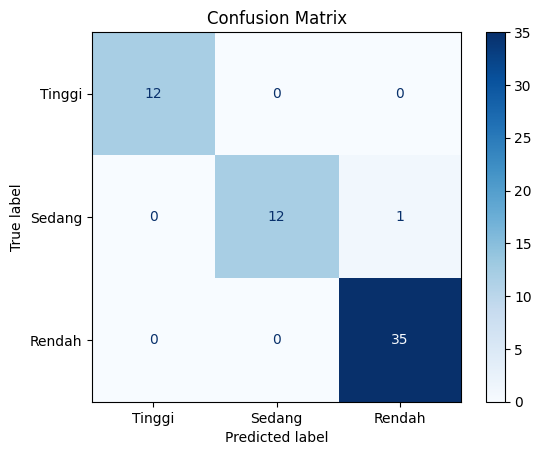

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['Tinggi', 'Sedang', 'Rendah'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Tinggi', 'Sedang', 'Rendah'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [14]:
# Tambahkan prediksi dan prioritas
data['Prediksi Kelas'] = knn.predict(X_scaled)
data['Prioritas'] = data['Prediksi Kelas'].map({'Tinggi': 1, 'Sedang': 2, 'Rendah': 3})
data_sorted = data.sort_values('Prioritas')

In [15]:
# Tampilkan jalan prioritas tertinggi
print("\n=== 10 Jalan dengan Prioritas Tertinggi ===")
print(data_sorted[['Nama Ruas Jalan', 'Total Kerusakan (%)', 'Prediksi Kelas', 'Prioritas']].head(10))


=== 10 Jalan dengan Prioritas Tertinggi ===
    Nama Ruas Jalan  Total Kerusakan (%) Prediksi Kelas  Prioritas
57              TPA               100.00         Tinggi          1
62         BUMIREJO                88.33         Tinggi          1
61       MUKTIHARJO                60.00         Tinggi          1
59          BADEGAN                66.23         Tinggi          1
42        H. MUNADI                77.61         Tinggi          1
35             PURI                73.33         Tinggi          1
77    JL. HANG TUAH                71.83         Tinggi          1
80      JL. KRAPYAK                64.29         Tinggi          1
131            TAYU                51.81         Tinggi          1
104      TLOGOWUNGU                94.27         Tinggi          1


In [19]:
import joblib

# Simpan model KNN
joblib.dump(knn, 'model_knn_prioritas_jalan.pkl')

# Simpan hasil klasifikasi dan prioritas ke CSV
data_sorted.to_csv('hasil_klasifikasi_prioritas_jalan.csv', index=False)


print("Model dan Hasil Klasifikasi Berhasil di simpan!")


Model dan Hasil Klasifikasi Berhasil di simpan!
